In [21]:
import pandas as pd
import numpy as np
import cv2
import os
import matplotlib.pyplot as plt
from skimage.filters import threshold_otsu
base_path = "../CBIS-DDSM_Clean_Data/"
train = pd.read_csv(base_path + "train_full.csv")

In [153]:
image_path = os.path.join("../",(train["image_path"].iloc[2]))
image_path

'../CBIS-DDSM_Clean_Data/labeled_images_png/1.3.6.1.4.1.9590.100.1.2.100631678311747240317898717702514834166_full.png'

# Background Removal

In [154]:
def background_removal(image):

    # smooth image
    blur_img = cv2.GaussianBlur(image, (5,5), 0)

    # gets Otsu threshold 
    _, thresh = cv2.threshold(blur_img, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU) 

    # apply morphological closing to make sure parts of the breast are not removed 
    kernel = np.ones((15, 15), np.uint8) 
    closed_img = cv2.morphologyEx(thresh, cv2.MORPH_CLOSE, kernel)

    # Identify connecting regions for each pixel edge and corner (8) of binary image 
    num_labels, labels, stats, _ = cv2.connectedComponentsWithStats(closed_img, connectivity=8)

    # find the largest component that is connected
    largest_label = 1 + np.argmax(stats[1:, cv2.CC_STAT_AREA])
    
    # generate mask of black background
    mask = (labels == largest_label).astype(np.uint8) * 255
    breast_img = cv2.bitwise_and(image, image, mask=mask)
    
    
    
    
    plt.figure(figsize=(12,6))
    plt.subplot(1,4,1)
    plt.title("Original")
    plt.imshow(image, cmap='gray')
    plt.axis('off')
    
    plt.subplot(1,4,2)
    plt.title("Closed")
    plt.imshow(closed_img, cmap='gray')
    plt.axis('off')
    
    plt.subplot(1,4,3)
    plt.title("Otsu Mask")
    plt.imshow(mask, cmap='gray')
    plt.axis('off')
    
    plt.subplot(1,4,4)
    plt.title("Cleaned Breast")
    plt.imshow(breast_img, cmap='gray')
    plt.axis('off')
    
    plt.show()
    return breast_img, mask

In [155]:
images = {}
images["original"] = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)


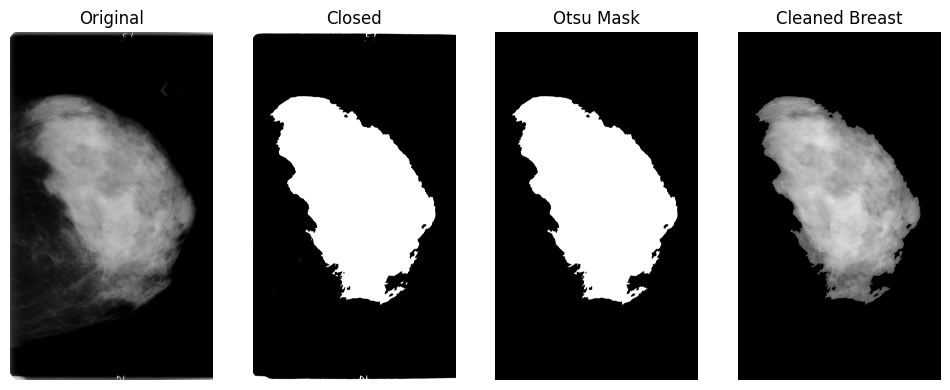

In [156]:
breast_img, mask = background_removal(images["original"])

# Crop and resizing

In [157]:
def crop(image, breast_mask):
    
    # find contours of breast image using the mask. 
    # - RETR_EXTERNAL: defines only external countour of the biggest section, 
    # - CHAIN_APPROX_SIMPLE: saves only non redundant and the simplest points of the countour 
    # source: https://medium.com/analytics-vidhya/opencv-findcontours-detailed-guide-692ee19eeb18
    contours, _ = cv2.findContours(breast_mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    print("--------------\n",contours)
    
    # checks for non-countour
    if len(contours) == 0:
        return image

    # find the countour area
    # source: https://docs.opencv.org/3.4/dd/d49/tutorial_py_contour_features.html
    area = max(contours, key=cv2.contourArea)
    print("--------------\n",area)
    
    # find the bounding box
    x, y, w, h = cv2.boundingRect(area)
    print("--------------\n",x, y, w, h)

    # crops image using bounding box
    cropped = image[y:y+h, x:x+w]
    print("C-------------\n",print(cropped))

    plt.figure(figsize=(12,6))
    plt.subplot(1,2,1)
    plt.title("No Background")
    plt.imshow(breast_img, cmap='gray')
    plt.axis('off')
    
    plt.subplot(1,2,2)
    plt.title("Cropped")
    plt.imshow(cropped, cmap='gray')
    plt.axis('off')

    plt.show()
    
    return cropped

--------------
 (array([[[ 882, 1116]],

       [[ 880, 1118]],

       [[ 863, 1118]],

       ...,

       [[ 895, 1122]],

       [[ 894, 1121]],

       [[ 894, 1116]]], dtype=int32),)
--------------
 [[[ 882 1116]]

 [[ 880 1118]]

 [[ 863 1118]]

 ...

 [[ 895 1122]]

 [[ 894 1121]]

 [[ 894 1116]]]
--------------
 293 1116 2842 3581
[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]
C-------------
 None


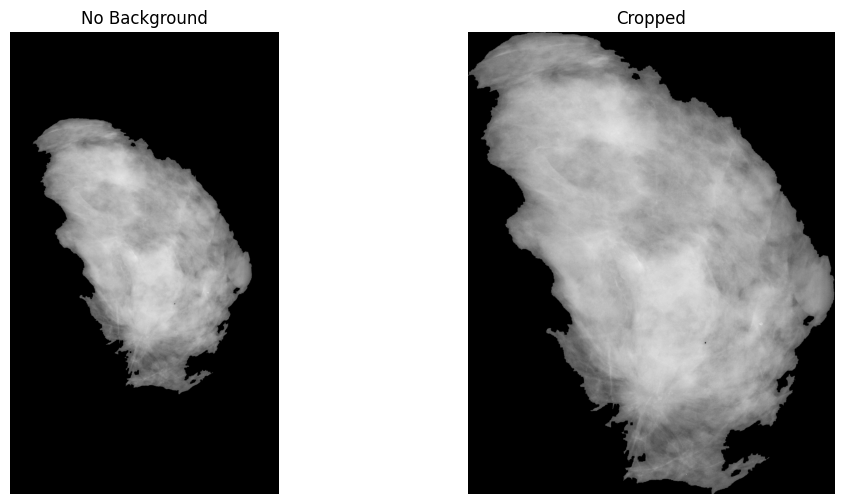

In [158]:
cropped = crop(breast_img, mask)